<a href="https://colab.research.google.com/github/jehasbani/directing-customers-to-subscription-through-app-behavior-analysis/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Directing customers to subscription through app behavior analysis

### Introduction
In today's market, many companies have a mobile presence. These companies often provide free products/services in their mobile apps in an attempt to transition their customers to a paid membership. Since marketing efforts cost money, companies need to know exactly who to target with offers and promotions.

In this case study, the targted audience are the people who use a company's free product (i.e. installed the company's free mobile app). The goal in this project is to predict which users will not subscribe to the paid membership, so that greater marketing efforts can go into trying to "convert" them to paid customers.

### Data
The data we are going to use to perform this analysis is comprised of the date and time of the app installation, the features the users engaged with within the app, among others. App behaviour is characterized as the list of app screens the user looked at and whether the user played the financial mini-games available. The app usage data is only from the user's first day in the app. This limitation exists because users can only access a 24-hour free trial in which they can use all of the app's premium features, and the company wants to target them with new offers shortly after the trial is over.

*Note: The data used in this project is synthetic due to the fact that this kind of dataset is not openly available as it contains business information not to be divulged. Nevertheless, the trends and patterns contained in this dataset are very much representative of a real world use case.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
import os

In [21]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Importing data

In [ ]:
url = "https://raw.githubusercontent.com/jehasbani/directing-customers-to-subscription-through-app-behavior-analysis/main/data/appdata10.csv"
df = pd.read_csv(url)
df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


Let's break down what each column represents:

- **user**: unique numerical id for the users.
- **first_open**: Date and time in which the user opens the app for the first time. It's a good way to see when the user joins.
- **dayofweek**: Represents the day of the week in numerical form, i.e. 0 = Sunday, 1 = Monday, etc.
- **hour**: The hour of the day.
- **age**: user's age.
- **screen_list**: Describes every single screen name the user visited in the 24 hour trial.
- **numscreens**: Quantity of screens the user visited
- **minigame**: Indicates whether the user played the mini-game.
- **used_premium_features**: Indicates whether the user took advantage of the premium features during the trial.
- **enrolled**: Target variable. Indicates whether the user got the paid version.
- **enrolled_date**: Date and time in which the user got the paid membership.
- **liked**: Indicates whether the user liked a feature.

## Exploratory Data Analysis

Let's review the data types and check for nulls:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   user                  50000 non-null  int64 
 1   first_open            50000 non-null  object
 2   dayofweek             50000 non-null  int64 
 3   hour                  50000 non-null  object
 4   age                   50000 non-null  int64 
 5   screen_list           50000 non-null  object
 6   numscreens            50000 non-null  int64 
 7   minigame              50000 non-null  int64 
 8   used_premium_feature  50000 non-null  int64 
 9   enrolled              50000 non-null  int64 
 10  enrolled_date         31074 non-null  object
 11  liked                 50000 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 4.6+ MB


Since the field ``hour`` is of type String, we can convert it to numerical

In [ ]:
df['hour'] = df.hour.str.slice(1,3).astype(int)

We can start the analysis with a simple statistical description of the data.

In [ ]:
df.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,12.557220,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,7.438072,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,5.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,14.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,19.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,23.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


Let's divide the columns in numerical an non numerical, and create a dataframe that only has numerical variables (without user and enrolled) for plotting purposes.

In [ ]:
num_col = list(df.describe().columns)
non_num_col = list(set(df.columns).difference(num_col))

In [ ]:
df_numerical = df.copy()[num_col].drop(columns=['user','enrolled'])

### Histograms

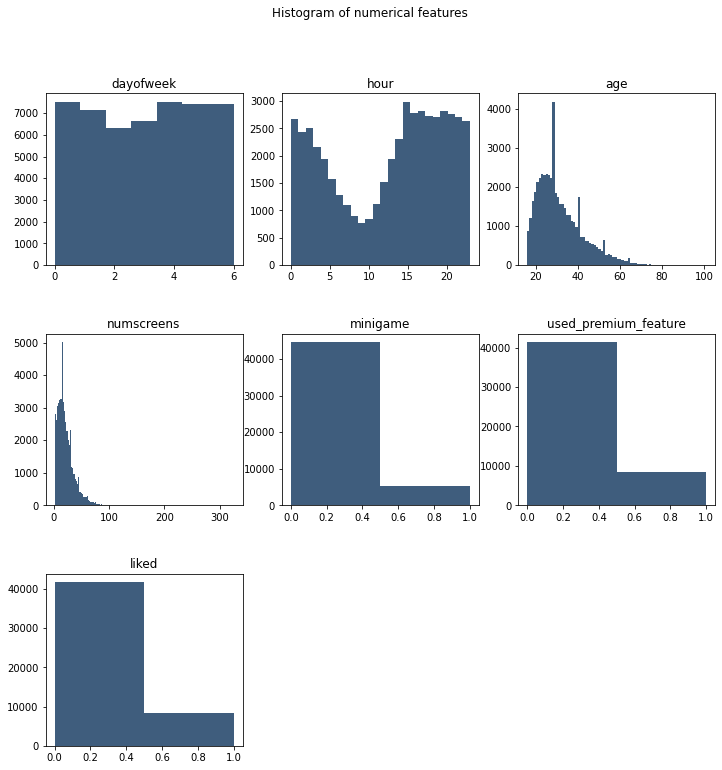

In [ ]:
fig,axes = plt.subplots(3,3, figsize=(12,12))

axes = axes.ravel()
for ax in axes:
  ax.set_axis_off()

plt.suptitle('Histogram of numerical features')
for i,col in enumerate(df_numerical.columns):
  axes[i].set_title(col)

  vals = np.size(df_numerical[col].unique())
  axes[i].hist(df_numerical[col].values, bins = vals, color = '#3f5d7d')
  axes[i].set_axis_on()

plt.subplots_adjust(hspace=0.4)


Key histogram takeaways:

- **dayofweek** is uniformly distributed, which gives us no insight as to whether there's a dependency on the day of the week.
- **hour** shows a significant decrease in the app usage around certain hour (which if we coverted it to the correct time zone it would surely match the evening).
- **age** show that the users are mostly between 20 and 40 years old, with a peaks at around 30 years old.
- **numscreens** is heavily skewed.
- Most users did not play the mini game, did not use the premium features and did not like the features.

### Correlation with response variable

Here'll search for correlations between the features and the response variable to see whether there is a linear relationship in the data we can exploit.

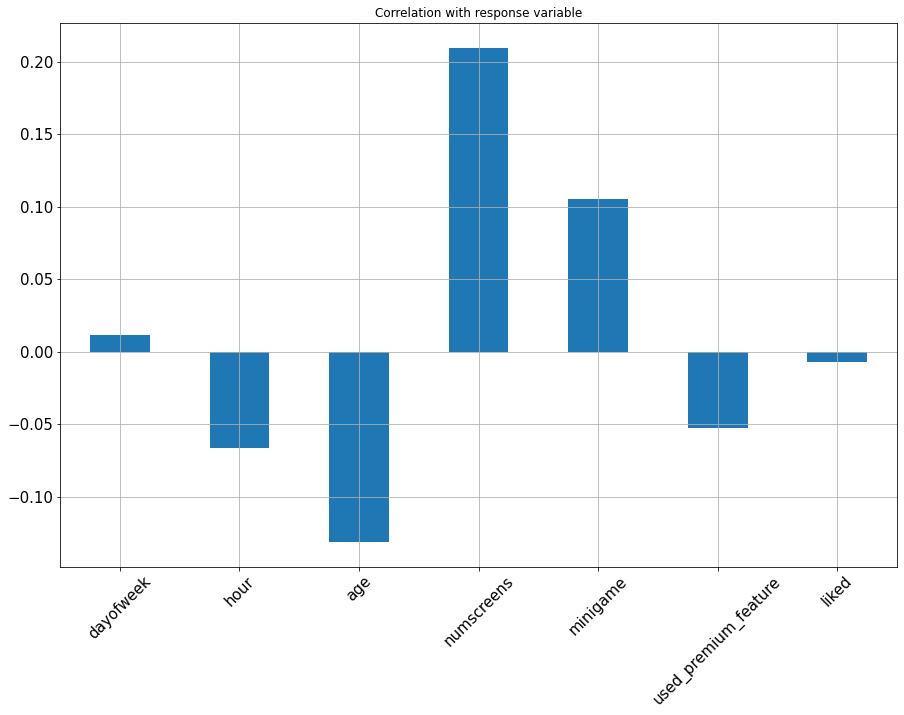

In [ ]:
df_numerical.corrwith(df.enrolled).plot.bar(figsize = (15,10), 
                                            title = "Correlation with response variable",
                                            fontsize=15, rot=45, grid = True)

Since the highest positive correlation is around 0.2 and the lowest negative correlation is around 0.15 we can't conclude there is a linear relationship between any of the features and the target.

---

### Correlation Matrix

Now we'll search for correlation between the features to identify **multicollinearity**. Multicollinearity occurs when independent variables are correlated. This correlation is a problem because independent variables should be independent. If the degree of correlation between variables is high enough, it can cause problems when you train your model and interpret the results.

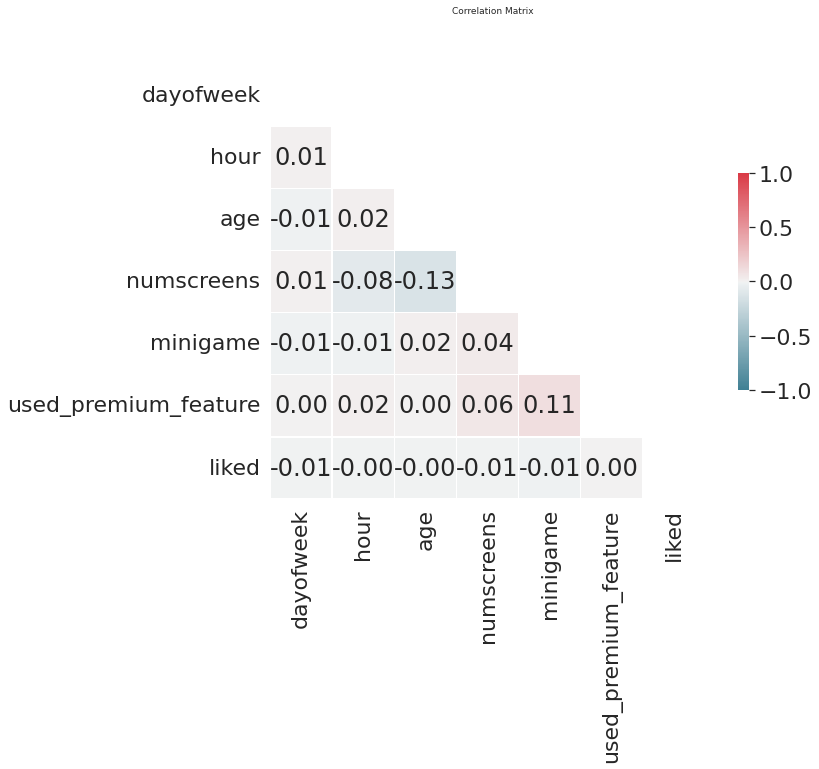

In [ ]:
sns.set(style='white',font_scale=2)

# compute the correlation matrix
corr = df_numerical.corr()

# generate a mask for the upper triangle
mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize = (12,8))
f.suptitle("Correlation Matrix", fontsize=9)

# generate a colormap
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(corr,
            mask=mask,
            cmap=cmap, 
            vmax=1, vmin = -1, 
            center=0, 
            square=True, 
            linewidths=0.5, 
            cbar_kws={"shrink":0.5},
             annot=True,fmt='.2f')
plt.show()

We see that the varibles are not correlated with each other, which means we can treat them as independent.

---

## Feature Engineering


### Response Variable

We will start by finetuning the response variable. It's important because we need to set a limit to when a user will become a paid member due to the fact that we need to have a way to validate the model in future data points (i.e if we set the time limit to a week, then we only need to wait for a week before we know if the prediction the model made was accurate). But first, we need to find the optimal cut-off time for this purpose:

In [ ]:
df.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int64
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

We need to converte the date fields into datetime objects

In [ ]:
df.first_open = [parser.parse(row) for row in df.first_open]

In [ ]:
df.enrolled_date = [parser.parse(row) if isinstance(row,str) else row for row in df.enrolled_date]

In [ ]:
df.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int64
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

Let's create the column `difference` that is nothing but the difference in hours between the parsed `enrolled_date` column and the parsed `first_open` column:

In [ ]:
df['difference'] = (df['enrolled_date']-df['first_open']).astype('timedelta64[h]')

Now, we can see how the time difference is distributed:

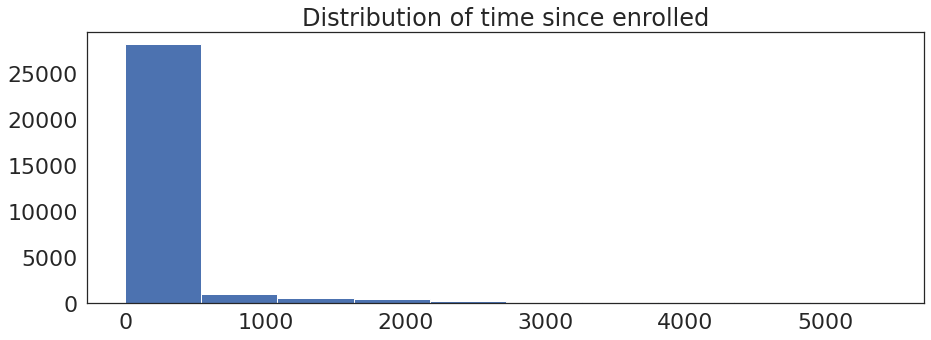

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(df['difference'].dropna())
plt.title('Distribution of time since enrolled')
plt.show()

Most of the conversions happen in the first 500 hours, but let's reduce the range to the first 100 hours:

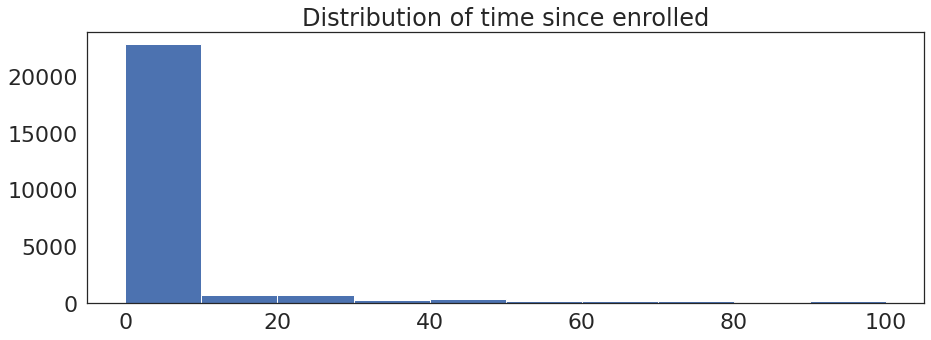

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(df['difference'].dropna(), range=[0,100])
plt.title('Distribution of time since enrolled')
plt.show()

If we analyze this distribution, we see that we can set a cut-off time of 48 hours (two days) to the response variable and that will include the majority of the events based on the distribution we just analyzed. So, now we have to set all of the users in which `difference` > 48 to 0:


In [ ]:
df.loc[df.difference > 48 ,'enrolled'] = 0

Now, we can drop the columns which are no longer needed

In [ ]:
df.drop(columns=['enrolled_date','first_open','difference'],inplace=True)

### Screens

The `screen_list` is a list that contains every single screen name the user visited in the 24 hour trial. We need to convert this list into a format the model can consume. We can achieve this by giving each screen its own column. However, since there are too many screens doing this one-hot-encoding would blow up our dataframe. 

In this case scenario we have a new dataset at our disposal which contains the screens people used the most. We are going to leverage this dataset in order to pick which columns should be encoded into our features.

In [ ]:
top_screens_url = url = "https://raw.githubusercontent.com/jehasbani/directing-customers-to-subscription-through-app-behavior-analysis/main/data/top_screens.csv"
top_screens = pd.read_csv(top_screens_url).top_screens
top_screens.head()

0               Loan2
1            location
2        Institutions
3    Credit3Container
4         VerifyPhone
Name: top_screens, dtype: object

Now we can map this top screens into our dataset:

In [ ]:
df["screen_list"] = df.screen_list.astype(str)+","

In [ ]:
for sc in top_screens:
  df[sc] = df.screen_list.str.contains(sc).astype(int)
  df["screen_list"] = df.screen_list.str.replace(sc+",","")

We don't want to lose the information provided by the leftover screens that were not included in the top screens, so we create another column called `other` that contains how many other screens the user visited.

In [ ]:
df["other"] = df.screen_list.str.count(",")

In [ ]:
df.drop(columns = ["screen_list"], inplace=True)

### Funnels

There are screens correlated to each other, and the form **funnels**. We should group these columns together so that we don't have correlated columns in our dataset.

In [ ]:
np.sort(top_screens)

array(['AccountView', 'Alerts', 'BankVerification', 'CC1', 'CC1Category',
       'CC3', 'Credit1', 'Credit2', 'Credit3', 'Credit3Container',
       'Credit3Dashboard', 'Cycle', 'EditProfile', 'Finances',
       'Institutions', 'Leaderboard', 'ListPicker', 'Loan', 'Loan2',
       'Loan3', 'Loan4', 'Login', 'NetworkFailure', 'ProfileChildren ',
       'ProfileEducation', 'ProfileEducationMajor',
       'ProfileEmploymentLength', 'ProfileJobTitle',
       'ProfileMaritalStatus', 'ProfilePage', 'ResendToken',
       'RewardDetail', 'Rewards', 'RewardsContainer', 'Saving1',
       'Saving10', 'Saving2', 'Saving2Amount', 'Saving4', 'Saving5',
       'Saving6', 'Saving7', 'Saving8', 'Saving9', 'SecurityModal',
       'Splash', 'TransactionList', 'VerifyAnnualIncome', 'VerifyCountry',
       'VerifyDateOfBirth', 'VerifyHousing', 'VerifyHousingAmount',
       'VerifyIncomeType', 'VerifyMobile', 'VerifyPhone', 'WebView',
       'idscreen', 'location'], dtype=object)

In [ ]:
# Credit card funnel
cc_screens = ['CC1', 
              'CC1Category',
              'CC3']
df["cc_count"] = df[cc_screens].sum(axis=1)
df.drop(columns = cc_screens, inplace=True)

In [ ]:
# Credit Funnel
credit_screens = ['Credit1', 
                  'Credit2',
                  'Credit3', 
                  'Credit3Container',
                  'Credit3Dashboard']
df["credit_count"] = df[credit_screens].sum(axis=1)
df.drop(columns = credit_screens, inplace=True)

In [ ]:
# Loan Funnel
loan_screens = ['Loan', 
                'Loan2', 
                'Loan3', 
                'Loan4']
df["loan_count"] = df[loan_screens].sum(axis=1)
df.drop(columns = loan_screens, inplace=True)

In [ ]:
# Savings funnel
savings_screens = ["Saving1", 
                   "Saving2", 
                   "Saving2Amount", 
                   "Saving4", 
                   "Saving5", 
                   "Saving6", 
                   "Saving7",
                   "Saving8",
                   "Saving9",
                   "Saving10"]
df["savings_count"] = df[savings_screens].sum(axis=1)
df.drop(columns = savings_screens, inplace=True)

Let's see what we ended up having:

In [ ]:
df.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,Institutions,VerifyPhone,BankVerification,VerifyDateOfBirth,ProfilePage,VerifyCountry,Cycle,idscreen,Splash,RewardsContainer,EditProfile,Finances,Alerts,Leaderboard,VerifyMobile,VerifyHousing,RewardDetail,VerifyHousingAmount,ProfileMaritalStatus,ProfileChildren,ProfileEducation,ProfileEducationMajor,Rewards,AccountView,VerifyAnnualIncome,VerifyIncomeType,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,other,cc_count,credit_count,loan_count,savings_count
0,235136,3,2,23,15,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,7,0,0,1,0
1,333588,6,1,24,13,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,1,0
2,254414,1,19,23,3,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,234192,4,16,28,40,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,3,1,0
4,51549,1,18,31,32,0,0,1,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,2,1,0


In [ ]:
df.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,Institutions,VerifyPhone,BankVerification,VerifyDateOfBirth,ProfilePage,VerifyCountry,Cycle,idscreen,Splash,RewardsContainer,EditProfile,Finances,Alerts,Leaderboard,VerifyMobile,VerifyHousing,RewardDetail,VerifyHousingAmount,ProfileMaritalStatus,ProfileChildren,ProfileEducation,ProfileEducationMajor,Rewards,AccountView,VerifyAnnualIncome,VerifyIncomeType,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,other,cc_count,credit_count,loan_count,savings_count
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,186889.729900,3.029860,12.557220,31.72436,21.095900,0.107820,0.172020,0.497000,0.165000,0.517760,0.293660,0.524600,0.319540,0.473480,0.158040,0.423160,0.364860,0.340700,0.200760,0.084000,0.048980,0.076540,0.073720,0.051520,0.053860,0.045080,0.030920,0.041420,0.047560,0.0,0.0455,0.041060,0.024420,0.026220,0.023580,0.031760,0.022460,0.029800,0.021160,0.096560,0.014220,0.013340,0.013400,0.008200,0.007580,6.214260,0.176860,0.92776,0.788400,0.365020
std,107768.520361,2.031997,7.438072,10.80331,15.728812,0.310156,0.377402,0.499996,0.371184,0.499689,0.455443,0.499399,0.466303,0.499301,0.364782,0.494065,0.481396,0.473949,0.400573,0.277391,0.215828,0.265863,0.261317,0.221058,0.225743,0.207482,0.173103,0.199262,0.212836,0.0,0.2084,0.198431,0.154351,0.159791,0.151738,0.175362,0.148176,0.170037,0.143919,0.295361,0.118398,0.114727,0.114981,0.090183,0.086733,3.672561,0.612787,1.21751,0.677462,1.405511
min,13.000000,0.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,93526.750000,1.000000,5.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.00000,0.000000,0.000000
50%,187193.500000,3.000000,14.000000,29.00000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.00000,1.000000,0.000000
75%,279984.250000,5.000000,19.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.00000,1.000000,0.000000
max,373662.000000,6.0

Finally we can save the preprocessed dataset to a separate file:

In [ ]:
df.to_csv(os.path.join(data_path,'new_app_data.csv'),index=False,header=True)

---

## Data Preprocessing

In [ ]:
import time

In [2]:
new_url = "https://raw.githubusercontent.com/jehasbani/directing-customers-to-subscription-through-app-behavior-analysis/main/data/new_app_data.csv"
df = pd.read_csv(new_url)

Separate response variable from independent features:

In [3]:
y = df.enrolled
X = df.drop(columns=['enrolled'])

Let's check the class distribution to detect class imbalance:

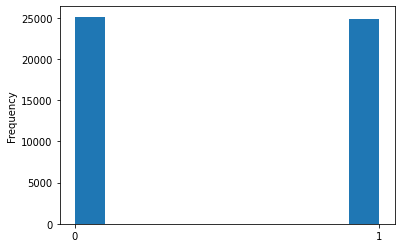

In [4]:
y.plot.hist()
plt.xticks([0,1])
plt.show()

Our dataset does not show class imbalance. So, we can split the data into training and testing datasets

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

Let's save the users id to have some way to identify the users later

In [7]:
train_ids = X_train.user
test_ids = X_test.user

X_train.drop(columns=['user'], inplace=True)
X_test.drop(columns=['user'], inplace=True)

Now, we can standardize the features:

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns, index=X_test.index)

## Metrics

A model performs as well as the metrics we choose to evaluate it with. If we select the wrong metrics we could end up with a false perception of high performance. In this particular example, since we don't have class imbalance, we can choose the classic metrics to perform model evaluation.

These are a few metrics computed by the model that will be helpful when evaluating the performance.


*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$

>   Note: Accuracy is not a helpful metric for this task. You can have a 99.8% accuracy on this task by predicting 8 all the time.  

*   **Precision** is the percentage of **predicted** positives that were correctly classified. Summarizes the fraction of examples assigned to the positive class that belong to the positive class.
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$

*   **Recall** is the percentage of **actual** positives that were correctly classified. Also known as **Sensitivity**, summarizes how well the positive class was predicted.
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$

*   **Specificity** is the percentage of **actual** negatives that were correctly classified. Summarises how well the negative class was predicted.
>   $\frac{\text{true negatives}}{\text{true negatives + false positives}}$

> Note: For imbalanced classification, the sensitivity might be more interesting than the specificity.


*   **F-Score**: combines **Precision** and **Recall** into a single metric
>   $\frac{2 * precision * recall}{precision + recall}$

>   The F-Score is a popular metric for imbalanced classification.

*   **F$_{\beta}$-Score** is an abstraction of the **F-Score** where the balance of precision and recall in the calculation of the harmonic mean is controlled by a coefficient called beta.
>   $\frac{(1+\beta^2) * precision * recall}{\beta^2*precision + recall}$

> The way to decide which F-Score to use is:
   * If FP and FP cost the same: F-Score
   * If FP are more costly: F$_{0.5}$-Score
   * If FN are more costly: F$_{2}$-Score
   
> Since in this case False Negatives impact on the business harder than False Positives, we choose F$_{2}$-Score

*   **ROC AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample. Although generally effective, the ROC Curve and ROC AUC can be optimistic under a severe class imbalance.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds. In this case, the focus on the minority class makes the Precision-Recall AUC more useful for imbalanced classification problems.

Thanks to this introduction we can then select the following metrics to evaluate our model for this problem:

* Accuracy
* Precision
* Recall
* F1-Score
* ROC Curve and AUC score
* PR Curve and AUC Score

Let's define some helper functions to evaluate the models:

In [10]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc

In [35]:
# Confusion matrix plot helper function
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  TN = cm[0][0]
  FP = cm[0][1]
  FN = cm[1][0]
  TP = cm[1][1]

  accuracy = (TP+TN)/(TP+TN+FP+FN)
  precision = TP / (TP+FP)
  recall = TP / (TP+FN)
  specificity = TN / (TN+FP)
  f1_score = (2*precision*recall)/(precision + recall)
  roc_auc = roc_auc_score(labels, predictions)

  precision_arr, recall_arr, _ = precision_recall_curve(labels, predictions)
  auprc = auc(recall_arr,precision_arr)

  print(f"Metrics at {p} classification threshold")
  print('Legitimate Transactions Detected (True Negatives): ', TN )
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', FP )
  print('Fraudulent Transactions Missed (False Negatives): ', FN)
  print('Fraudulent Transactions Detected (True Positives): ', TP)
  print('Accuracy: ', accuracy)
  print('Precision: ', precision)
  print('Recall (Sensitivity): ',recall)
  print('Specificity: ',specificity)
  print('F1-Score: ',f1_score)
  print("PRC AUC Score: ",auprc)
  print('ROC AUC Score: ',roc_auc)
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [12]:
# ROC curve plot helper function
def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, _ = roc_curve(labels, predictions)

  custom_label = f"{name} - AUC = {roc_auc_score(labels,predictions):.3f}"
  plt.plot(100*fpr, 100*tpr, label=custom_label, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

# Best Threshold finder helper function
def roc_best_threshold(labels, predictions):
  fpr, tpr, thresholds = roc_curve(labels, predictions)
  J = tpr - fpr
  ix = np.argmax(J)
  best_thresh = thresholds[ix]
  return best_thresh

In [13]:
# PRC curve plot helper function
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    #plt.figure(figsize=(12, 10))
    custom_label = f"{name} - AUC = {auc(recall,precision):.3f}"
    plt.plot(precision, recall, label=custom_label, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

def prc_best_threshold(labels, predictions):
  precision, recall, thresholds = precision_recall_curve(labels, predictions)
  # convert to f score
  fscore = (2 * precision * recall) / (precision + recall)
  # locate the index of the largest f score
  ix = np.argmax(fscore)
  best_thresh = thresholds[ix]
  return best_thresh

---

## Model

As a baseline model we'll use a Logistic Reggression classifier.

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

Since we are working with mobile app data, there could be correlation between the screens. We addressed these correlations using funnels, but there could be other correlations we didn't take into account. Chances are there actually exist other correlations between the screens. For example, if there is a screen that always leads to the enrollment screen there will be a strong correlation between them, even though it's only a part of the workflow of the app and it doesn't carry any actual predictive weight. In that case, the logistict regression model will assing a large weight to this feature and the $l_1$ regularization penalizes these sort of cases. 

In [ ]:
clf = LogisticRegression(random_state=0, penalty = "l1", solver="saga")

*Note: we use 'saga' solver because it's compatible with the $l1$ regularization.*

In [ ]:
clf.fit(X_train_scaled,y_train)

LogisticRegression(penalty='l1', random_state=0, solver='saga')

Let's predict on the test set

In [ ]:
y_pred = clf.predict(X_test_scaled)

#### Plot ROC Curve

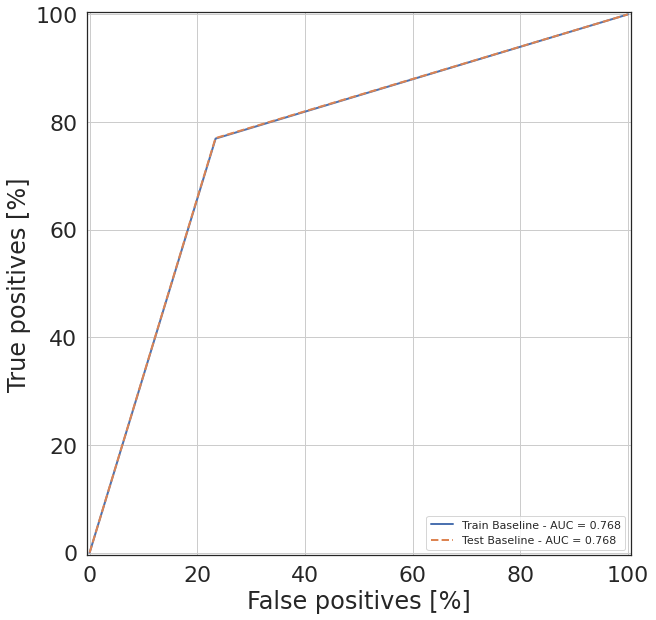

In [ ]:
plt.figure(figsize=(12,10))
plot_roc("Train Baseline", y_train, clf.predict(X_train_scaled), color=colors[0])
plot_roc("Test Baseline", y_test, y_pred, color=colors[1], linestyle='--')
plt.legend(loc='lower right',prop={'size': 11});

In [ ]:
roc_thr_baseline = roc_best_threshold(y_test, y_pred)
print("The best threshold for the ROC curve is: ",roc_thr_baseline)

The best threshold for the ROC curve is:  1


#### Evaluate Metrics

Metrics at 0.999 classification threshold
Legitimate Transactions Detected (True Negatives):  3886
Legitimate Transactions Incorrectly Detected (False Positives):  1186
Fraudulent Transactions Missed (False Negatives):  1133
Fraudulent Transactions Detected (True Positives):  3795
Accuracy:  0.7681
Precision:  0.7618952017667135
Recall (Sensitivity):  0.7700892857142857
Specificity:  0.7661671924290221
F1-Score:  0.3829851650015138
PRC AUC Score:  0.8226422437404997
ROC AUC Score:  0.7681282390716538
Total Fraudulent Transactions:  4928


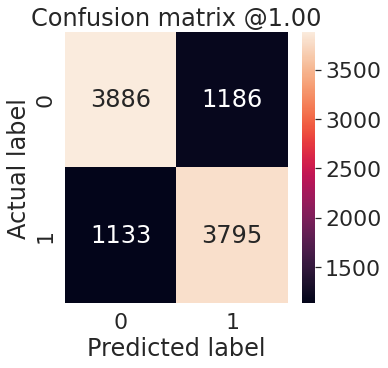

In [ ]:
plot_cm(y_test, y_pred, p=0.999)

#### Plot PR Curve

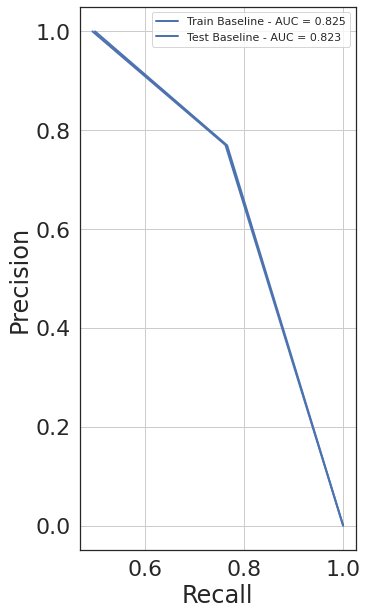

In [ ]:
plt.figure(figsize=(12,10))
plot_prc("Train Baseline", y_train, clf.predict(X_train_scaled), color=colors[0])
plot_prc("Test Baseline", y_test, y_pred, color=colors[0], linestyle='-')
plt.legend(loc='upper right',prop={'size': 11});

#### Cross Validation
Let's perform cross validation to have a more accurate sense of the model's performance

In [14]:
from sklearn.model_selection import cross_val_score, cross_validate

In [ ]:
scoring = ['accuracy','precision', 'recall','roc_auc']
scores = cross_validate(clf, X_train_scaled, y_train, scoring=scoring, cv=10)

In [ ]:
print(f"Logistic regression accuracy: {scores['test_accuracy'].mean():.4f} (+/- {scores['test_accuracy'].std()*2:.4f})")
print(f"Logistic regression precision: {scores['test_precision'].mean():.4f} (+/- {scores['test_precision'].std()*2:.4f})")
print(f"Logistic regression recall: {scores['test_recall'].mean():.4f} (+/- {scores['test_recall'].std()*2:.4f})")
print(f"Logistic regression ROC AUC score: {scores['test_roc_auc'].mean():.4f} (+/- {scores['test_roc_auc'].std()*2:.4f})")

Logistic regression accuracy: 0.7671 (+/- 0.0093)
Logistic regression precision: 0.7649 (+/- 0.0141)
Logistic regression recall: 0.7690 (+/- 0.0150)
Logistic regression ROC AUC score: 0.8403 (+/- 0.0083)


We see that our accuracy score of 76.71% is a good representation of the performance of the model.

### Gradient Boosted Trees

In [17]:
import xgboost as xgb

In [67]:
xgb_clf = xgb.XGBClassifier(n_estimators=100,random_state=0)

In [68]:
xgb_clf.fit(X_train_scaled,y_train)

XGBClassifier()

Let's predict on the test set

In [69]:
y_pred = xgb_clf.predict(X_test_scaled)

#### Plot ROC Curve

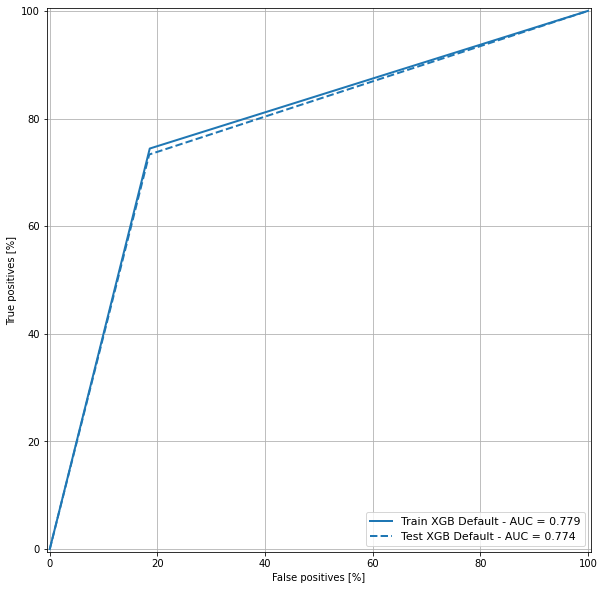

In [76]:
plt.figure(figsize=(12,10))
plot_roc("Train XGB Default", y_train, xgb_clf.predict(X_train_scaled), color=colors[0])
plot_roc("Test XGB Default", y_test,xgb_clf.predict(X_test_scaled), color=colors[0], linestyle='--')
plt.legend(loc='lower right',prop={'size': 11});

In [71]:
roc_thr_baseline = roc_best_threshold(y_test, y_pred)
print("The best threshold for the ROC curve is: ",roc_thr_baseline)

The best threshold for the ROC curve is:  1


#### Evaluate Metrics

Metrics at 0.999 classification threshold
Legitimate Transactions Detected (True Negatives):  4135
Legitimate Transactions Incorrectly Detected (False Positives):  937
Fraudulent Transactions Missed (False Negatives):  1315
Fraudulent Transactions Detected (True Positives):  3613
Accuracy:  0.7748
Precision:  0.7940659340659341
Recall (Sensitivity):  0.7331574675324676
Specificity:  0.8152602523659306
F1-Score:  0.762397130196244
PRC AUC Score:  0.8293617007992009
ROC AUC Score:  0.7742088599491991
Total Fraudulent Transactions:  4928


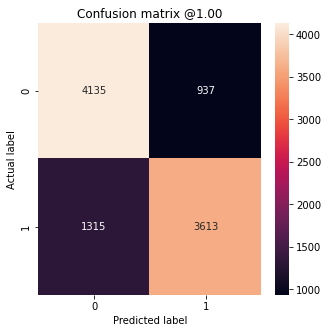

In [72]:
plot_cm(y_test, y_pred, p=0.999)

#### Plot PR Curve

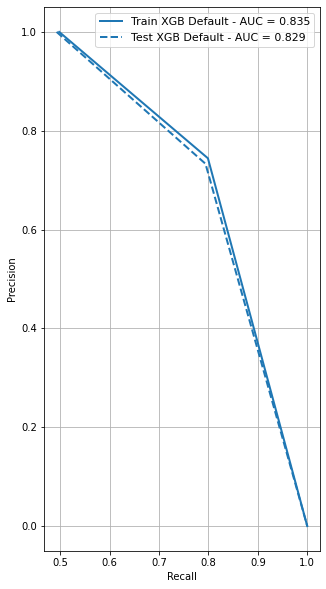

In [75]:
plt.figure(figsize=(12,10))
plot_prc("Train XGB Default", y_train, xgb_clf.predict(X_train_scaled), color=colors[0])
plot_prc("Test XGB Default", y_test, xgb_clf.predict(X_test_scaled), color=colors[0], linestyle='--')
plt.legend(loc='upper right',prop={'size': 11});

#### Cross Validation
Let's perform cross validation to have a more accurate sense of the model's performance

In [52]:
scoring = ['accuracy','precision', 'recall','roc_auc']
scores = cross_validate(xgb_clf, X_train_scaled, y_train, scoring=scoring, cv=10)

In [53]:
print(f"XGBT accuracy: {scores['test_accuracy'].mean():.4f} (+/- {scores['test_accuracy'].std()*2:.4f})")
print(f"XGBT precision: {scores['test_precision'].mean():.4f} (+/- {scores['test_precision'].std()*2:.4f})")
print(f"XGBT recall: {scores['test_recall'].mean():.4f} (+/- {scores['test_recall'].std()*2:.4f})")
print(f"XGBT ROC AUC score: {scores['test_roc_auc'].mean():.4f} (+/- {scores['test_roc_auc'].std()*2:.4f})")

XGBT accuracy: 0.7777 (+/- 0.0121)
XGBT precision: 0.7967 (+/- 0.0148)
XGBT recall: 0.7436 (+/- 0.0215)
XGBT ROC AUC score: 0.8554 (+/- 0.0091)


We can see how there's a slight improvement in the performance with the GBT

---

## Improving the model
To achieve better performance que can finetune the parameters of the LR, which there aren't many, or we can try out a completely different model. In this case, we'll train  XGB Classifier using a randomized grid search because it's a very well performant and common go-to model in the community.


#### GridSearch

In [15]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [54]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic')
params = dict(clf__eta = [0.01, 0.1, 0.5] ,
              clf__min_child_weight = [1, 5, 10],
              clf__gamma = [0,0.5, 1],
              clf__subsample = [0, 0.5, 1],
              clf__colsample_bytree = [0.1, 0.5, 1.0],
              clf__max_depth = [3, 6, 9])

grid = RandomizedSearchCV(xgb_clf, param_distributions=params, cv=10, n_jobs=-1, verbose=1, scoring='roc_auc', n_iter=50)
grid.fit(X_train_scaled, y_train)
print(grid.best_score_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
0.8554465707913229


In [62]:
grid.best_params_

{'clf__colsample_bytree': 0.1,
 'clf__eta': 0.5,
 'clf__gamma': 0.5,
 'clf__max_depth': 6,
 'clf__min_child_weight': 1,
 'clf__subsample': 0}

In [78]:
xgb_grid_clf = grid.best_estimator_
y_pred = xgb_grid_clf.predict(X_test_scaled)

#### Plot ROC Curve

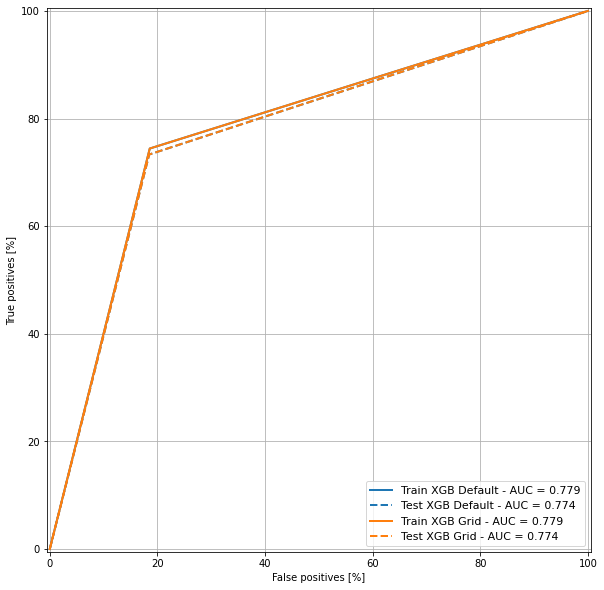

In [79]:
plt.figure(figsize=(12,10))
plot_roc("Train XGB Default", y_train, xgb_clf.predict(X_train_scaled), color=colors[0])
plot_roc("Test XGB Default", y_test,xgb_clf.predict(X_test_scaled), color=colors[0], linestyle='--')
plot_roc("Train XGB Grid", y_train, xgb_grid_clf.predict(X_train_scaled), color=colors[1])
plot_roc("Test XGB Grid", y_test, xgb_grid_clf.predict(X_test_scaled), color=colors[1], linestyle='--')
plt.legend(loc='lower right',prop={'size': 11});

In [65]:
roc_thr_baseline = roc_best_threshold(y_test, y_pred)
print("The best threshold for the ROC curve is: ",roc_thr_baseline)

The best threshold for the ROC curve is:  1


#### Evaluate Metrics

Metrics at 0.999 classification threshold
Legitimate Transactions Detected (True Negatives):  4135
Legitimate Transactions Incorrectly Detected (False Positives):  937
Fraudulent Transactions Missed (False Negatives):  1315
Fraudulent Transactions Detected (True Positives):  3613
Accuracy:  0.7748
Precision:  0.7940659340659341
Recall (Sensitivity):  0.7331574675324676
Specificity:  0.8152602523659306
F1-Score:  0.762397130196244
PRC AUC Score:  0.8293617007992009
ROC AUC Score:  0.7742088599491991
Total Fraudulent Transactions:  4928


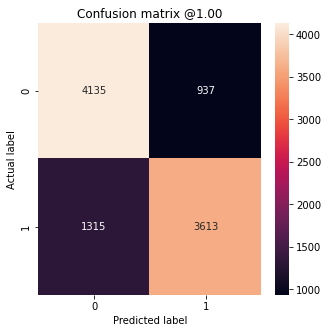

In [66]:
plot_cm(y_test, y_pred, p=0.999)

#### Plot PR Curve

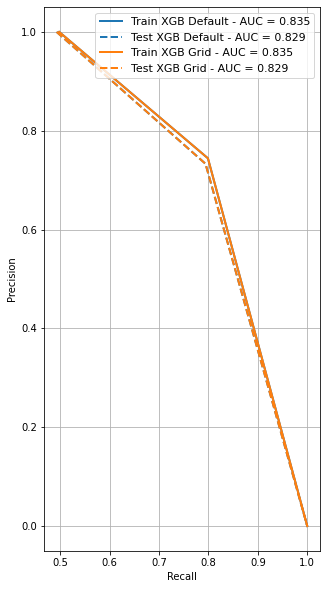

In [80]:
plt.figure(figsize=(12,10))
plot_prc("Train XGB Default", y_train, xgb_clf.predict(X_train_scaled), color=colors[0])
plot_prc("Test XGB Default", y_test, xgb_clf.predict(X_test_scaled), color=colors[0], linestyle='--')
plot_prc("Train XGB Grid", y_train, xgb_grid_clf.predict(X_train_scaled), color=colors[1])
plot_prc("Test XGB Grid", y_test, xgb_grid_clf.predict(X_test_scaled), color=colors[1], linestyle='--')
plt.legend(loc='upper right',prop={'size': 11});

#### Cross Validation
Let's perform cross validation to have a more accurate sense of the model's performance

In [60]:
scoring = ['accuracy','precision', 'recall','roc_auc']
scores = cross_validate(xgb_grid_clf, X_train_scaled, y_train, scoring=scoring, cv=10)

In [61]:
print(f"XGBT accuracy: {scores['test_accuracy'].mean():.4f} (+/- {scores['test_accuracy'].std()*2:.4f})")
print(f"XGBT precision: {scores['test_precision'].mean():.4f} (+/- {scores['test_precision'].std()*2:.4f})")
print(f"XGBT recall: {scores['test_recall'].mean():.4f} (+/- {scores['test_recall'].std()*2:.4f})")
print(f"XGBT ROC AUC score: {scores['test_roc_auc'].mean():.4f} (+/- {scores['test_roc_auc'].std()*2:.4f})")

XGBT accuracy: 0.7777 (+/- 0.0121)
XGBT precision: 0.7967 (+/- 0.0148)
XGBT recall: 0.7436 (+/- 0.0215)
XGBT ROC AUC score: 0.8554 (+/- 0.0091)


We can see that the tuned XGB yields the same results as the default XGB classifier. Maybe we could select a wider parameter grid to capture a performance improvement in a different configuration.

Comparing the CV results of the XGB to the results for the logistic regression model, we can notice that there's a small improvement in performance in the XGB model. However, it could be argued that the extra complexity the XGB brings to the table is not worth the improvemente for the use case.

Finally, let's match each prediction to the users:

In [ ]:
final_results = pd.concat([y_test,test_ids], axis=1).dropna()
final_results['prediction'] = y_pred
final_results[['user','enrolled','prediction']].reset_index(drop=True)

,user,enrolled,prediction
0,239786,1,1
1,279644,1,1
2,98290,0,0
3,170150,1,1
4,237568,1,0
...,...,...,...
9995,143036,1,1
9996,91158,1,1
9997,248318,0,0
9998,142418,1,1


---

## Conclusion

Thus far we have managed to develop a model that will label a user as "likely" or "unlikely" to subscribe. We can further validate the results by running the predictions on daily new installs, and see whether the model's performance is consistent. From there, the company can focus their marketing efforts towards those user "unlikely" to subscribe in order to increase their subscription rate. 

It is important to emphasize that the model's goal is to identify those users as "likely" or "unlikely" to subscribe because it defines to which extent it's acceptable for the model to be wrong. In this case, a 76% accuracy means that, even though the model makes mistakes, the predictions are useful for the business because of what the business goals are. If this model were to be used to predict whether a patient has a terminal disease, then a 76% accuracy would render the model useless.

The benefit of this model to the can be measured as the increase in the overall subscriptions. Let's remember that those already likely to subscribe will continue to do so, so we don't have to specifically target them. On the other hand, users who are likely to leave may convert to paid subscribers if we give extend great offers to them.